# Uvod

# Opis implementacije

### Učitavanje podataka

In [4]:
import pandas as pd

# Učitavanje CSV datoteke
csv_path = "US_Accidents_March23.csv"
df_csv = pd.read_csv(csv_path)

# Učitavanje XLSX datoteke
xlsx_path = "Electric_Vehicle_Population_Data.xlsx"
df_xlsx = pd.read_excel(xlsx_path)

df_csv = df_csv.sample(n=5000, random_state=42)
df_xlsx = df_xlsx.sample(n=5000, random_state=42)

### Čiščenje podataka

In [6]:
# Uklanjanje dupliciranih redova
df_csv = df_csv.drop_duplicates()
df_xlsx = df_xlsx.drop_duplicates()

#Formatiranje vremena
df_csv["Start_Time"] = df_csv["Start_Time"].str.split('.').str[0]
df_csv["End_Time"] = df_csv["End_Time"].str.split('.').str[0]

df_csv["Start_Time"] = pd.to_datetime(df_csv["Start_Time"])
df_csv["End_Time"] = pd.to_datetime(df_csv["End_Time"])

# Uklanjanje nepotrebnih stupaca
df_csv = df_csv.drop(columns=["ID", "Source", "Severity", "Start_Lat", "Start_Lng",
                              "End_Lat", "End_Lng", "Distance(mi)", "Description", "Street",
                              "Zipcode", "Country", "Timezone", "Airport_Code",
                              "Weather_Timestamp", "Temperature(F)", "Wind_Chill(F)", "Humidity(%)",
                              "Pressure(in)", "Visibility(mi)", "Wind_Direction", "Wind_Speed(mph)",
                              "Precipitation(in)", "Weather_Condition", "Amenity", "Bump",
                              "Crossing", "Give_Way", "Junction", "No_Exit", "Railway",
                              "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal",
                              "Turning_Loop", "Sunrise_Sunset", "Civil_Twilight",
                              "Nautical_Twilight", "Astronomical_Twilight"])
df_xlsx = df_xlsx.drop(columns=["VIN (1-10)", "City", "Postal Code", "Model Year",
                                "Electric Vehicle Type", "Clean Alternative Fuel Vehicle (CAFV) Eligibility",
                                "Electric Range", "Base MSRP", "Legislative District", "DOL Vehicle ID",
                                "Electric Utility", "Vehicle Location", "2020 Census Tract","County"])

# Obrada NaN vrijednosti (uklanjanje)
df_csv = df_csv.dropna()  
df_xlsx = df_xlsx.dropna()  

# Prikaz nakon čišćenja
print("\nCSV nakon čišćenja:")
print(df_csv.head())

print("\nXLSX nakon čišćenja:")
print(df_xlsx.head())


CSV nakon čišćenja:
                 Start_Time            End_Time             City      County  \
7133276 2020-04-17 09:29:30 2020-04-17 10:29:30  West Palm Beach  Palm Beach   
5363845 2022-04-21 10:01:00 2022-04-21 11:44:08        Roseville      Placer   
155993  2016-08-12 16:45:00 2016-08-12 17:15:00       Alpharetta      Fulton   
1861414 2019-09-20 15:22:16 2019-09-20 15:56:00           Tacoma      Pierce   
2021359 2019-06-03 16:55:43 2019-06-03 18:12:09       Scottsdale    Maricopa   

        State  
7133276    FL  
5363845    CA  
155993     GA  
1861414    WA  
2021359    AZ  

XLSX nakon čišćenja:
       State        Make     Model
61271     WA         BMW      530E
40997     WA    CHRYSLER  PACIFICA
124845    WA  VOLKSWAGEN    E-GOLF
124665    WA      NISSAN      LEAF
83879     WA     PORSCHE  PANAMERA


### Spajanje datasetova

In [8]:
merged_data = pd.merge(df_csv, df_xlsx, on="State", how="inner")

# Prikaz podataka
print("\nIntegrirani podaci:")
print(merged_data.head())



Integrirani podaci:
           Start_Time            End_Time             City      County State  \
0 2020-04-17 09:29:30 2020-04-17 10:29:30  West Palm Beach  Palm Beach    FL   
1 2022-04-21 10:01:00 2022-04-21 11:44:08        Roseville      Placer    CA   
2 2022-04-21 10:01:00 2022-04-21 11:44:08        Roseville      Placer    CA   
3 2022-04-21 10:01:00 2022-04-21 11:44:08        Roseville      Placer    CA   
4 2022-04-21 10:01:00 2022-04-21 11:44:08        Roseville      Placer    CA   

    Make    Model  
0  TESLA  MODEL 3  
1  TESLA  MODEL 3  
2  TESLA  MODEL Y  
3  TESLA  MODEL 3  
4  TESLA  MODEL 3  


### Uklanjanje podataka

In [10]:
print(f"Broj redova prije uklanjanja duplikata: {len(merged_data)}")

merged_data = merged_data.drop_duplicates()

print(f"Broj redova nakon uklanjanja duplikata: {len(merged_data)}")

Broj redova prije uklanjanja duplikata: 333065
Broj redova nakon uklanjanja duplikata: 10395


### Pohrana podataka u bazu

In [12]:
import sqlite3

# Spajanje na SQLite
conn = sqlite3.connect("project_data.db")

merged_data.to_sql("integrated_data", conn, if_exists="replace", index=False)

print("\nPrvih 5 redaka iz baze:")
print(pd.read_sql_query("SELECT * FROM integrated_data LIMIT 5;", conn))

conn.close()


Prvih 5 redaka iz baze:
            Start_Time             End_Time             City      County  \
0  2020-04-17 09:29:30  2020-04-17 10:29:30  West Palm Beach  Palm Beach   
1  2022-04-21 10:01:00  2022-04-21 11:44:08        Roseville      Placer   
2  2022-04-21 10:01:00  2022-04-21 11:44:08        Roseville      Placer   
3  2019-09-20 15:22:16  2019-09-20 15:56:00           Tacoma      Pierce   
4  2019-09-20 15:22:16  2019-09-20 15:56:00           Tacoma      Pierce   

  State      Make     Model  
0    FL     TESLA   MODEL 3  
1    CA     TESLA   MODEL 3  
2    CA     TESLA   MODEL Y  
3    WA       BMW      530E  
4    WA  CHRYSLER  PACIFICA  


### REST API

In [14]:
from flask import Flask, jsonify
import sqlite3
import pandas as pd

app = Flask(__name__)

# Početna ruta
@app.route('/', methods=['GET'])
def home():
    return jsonify({
        "message": "Welcome to the API. Use the following endpoints:",
        "all_data": "/api/data/all",
        "sample_data": "/api/data/sample"
    })

# Dohvaćanje uzorka podataka (100 redova)
@app.route('/api/data/sample', methods=['GET'])
def get_sample_data():
    conn = sqlite3.connect("project_data.db")
    query = "SELECT * FROM integrated_data LIMIT 100"
    data = pd.read_sql_query(query, conn)
    conn.close()
    return jsonify(data.to_dict(orient="records"))

# Dohvaćanje podataka po "STATE"
@app.route('/api/data/state/<state>', methods=['GET'])
def get_data_by_state(state):
    conn = sqlite3.connect("project_data.db")
    query = f"SELECT * FROM integrated_data WHERE State = '{state}'"
    data = pd.read_sql_query(query, conn)
    conn.close()
    return jsonify(data.to_dict(orient="records"))


from werkzeug.serving import run_simple

if __name__ == '__main__':
    run_simple('localhost', 5000, app)

 * Running on http://localhost:5000
Press CTRL+C to quit


### Vizualizacija

  State  Broj_nesreća  Broj_auta  Nesreće_po_autu
0    CA          2240          7       320.000000
1    CO           148          2        74.000000
2    CT            56          1        56.000000
3    FL           562          1       562.000000
4    ID             4          1         4.000000
5    MD           267          3        89.000000
6    NJ            89          1        89.000000
7    VA           204          1       204.000000
8    WA          6825       4983         1.369657


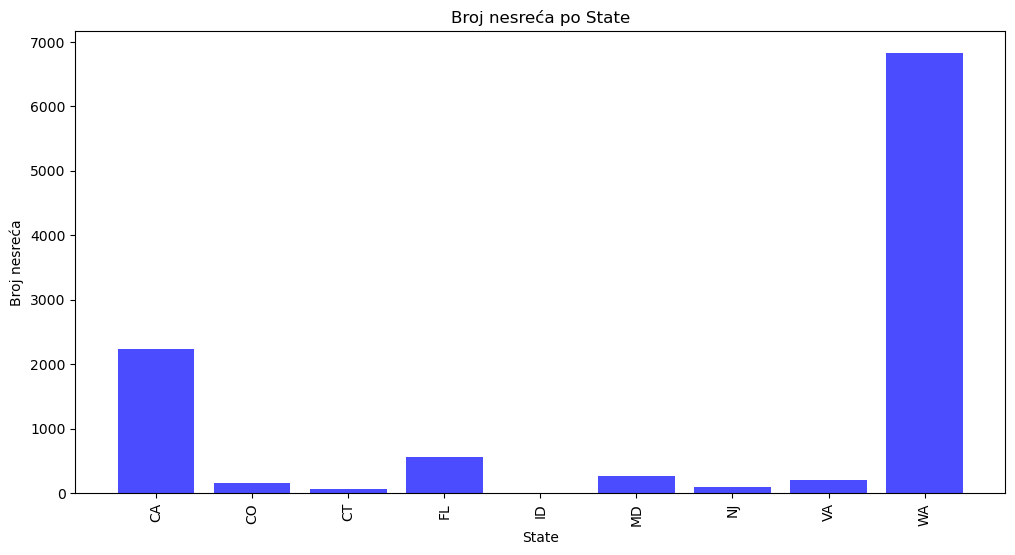

In [16]:
import matplotlib.pyplot as plt

nesrece_po_state = merged_data.groupby('State').size().reset_index(name='Broj_nesreća')

auta_po_state = df_xlsx.groupby('State').size().reset_index(name='Broj_auta')

analiza = pd.merge(nesrece_po_state, auta_po_state, on='State', how='inner')

analiza['Nesreće_po_autu'] = analiza['Broj_nesreća'] / analiza['Broj_auta']

print(analiza)

state_accidents = merged_data.groupby('State').size().reset_index(name='Broj_nesreća')

plt.figure(figsize=(12, 6))
plt.bar(state_accidents['State'], state_accidents['Broj_nesreća'], color='blue', alpha=0.7)
plt.xlabel('State')
plt.ylabel('Broj nesreća')
plt.title('Broj nesreća po State')
plt.xticks(rotation=90)
plt.show()


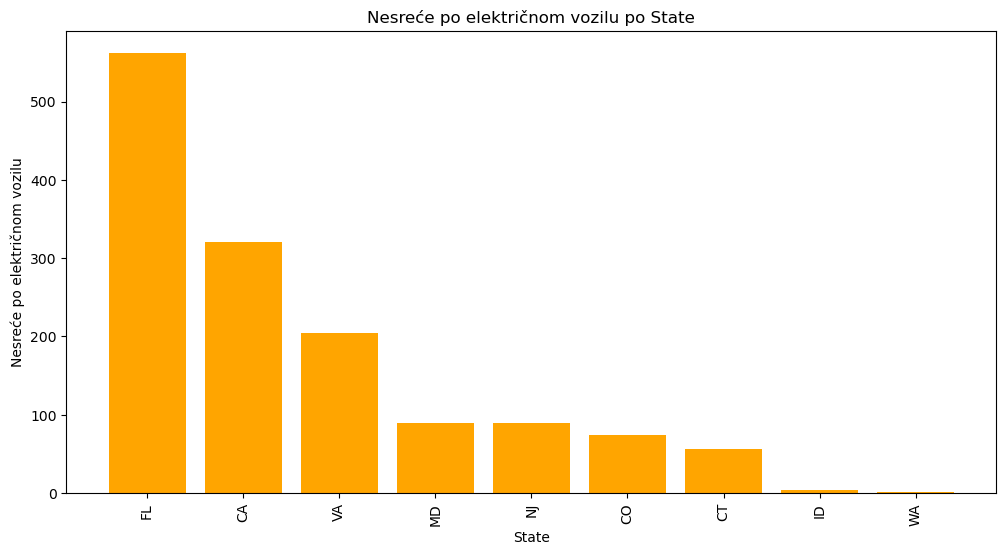

In [17]:
analiza = analiza.sort_values('Nesreće_po_autu', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(analiza['State'], analiza['Nesreće_po_autu'], color='orange')
plt.xlabel('State')
plt.ylabel('Nesreće po električnom vozilu')
plt.title('Nesreće po električnom vozilu po State')
plt.xticks(rotation=90)
plt.show()


# Prikaz aplikacije

![REST.png](REST.png)

![REST1.png](REST1.png)

![REST2.png](REST2.png)

# Kritički osvrt (izvedivost i primjena)

# Zaključak

# Literatura